In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
audit_trial_data <- read_csv("https://raw.githubusercontent.com/fulleraltamiranoe/audit_data/main/trial.csv")
audit_risk_data <- read_csv("https://raw.githubusercontent.com/fulleraltamiranoe/audit_data/main/audit_risk.csv")

Parsed with column specification:
cols(
  Sector_score = col_double(),
  LOCATION_ID = col_character(),
  PARA_A = col_double(),
  SCORE_A = col_double(),
  PARA_B = col_double(),
  SCORE_B = col_double(),
  TOTAL = col_double(),
  numbers = col_double(),
  Marks = col_double(),
  Money_Value = col_double(),
  MONEY_Marks = col_double(),
  District = col_double(),
  Loss = col_double(),
  LOSS_SCORE = col_double(),
  History = col_double(),
  History_score = col_double(),
  Score = col_double(),
  Risk = col_double()
)

Warning message:
“Duplicated column names deduplicated: 'Score_B' => 'Score_B_1' [11]”
Parsed with column specification:
cols(
  .default = col_double(),
  LOCATION_ID = col_character()
)

See spec(...) for full column specifications.



In [3]:
audit_trial_data
audit_risk_data

Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,6,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,6,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,14,0.24,2,0.04,2,0.28,5,2,0.00,2,2,0,2,0,2,2,0
55.57,18,0.20,2,0.00,2,0.20,5,2,0.00,2,2,0,2,0,2,2,0
55.57,15,0.00,2,0.00,2,0.00,5,2,0.32,2,2,0,2,0,2,2,0


Sector_score,LOCATION_ID,PARA_A,Score_A,Risk_A,PARA_B,Score_B,Risk_B,TOTAL,numbers,⋯,RiSk_E,History,Prob,Risk_F,Score,Inherent_Risk,CONTROL_RISK,Detection_Risk,Audit_Risk,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.89,23,4.18,0.6,2.508,2.50,0.2,0.500,6.68,5,⋯,0.4,0,0.2,0,2.4,8.574,0.4,0.5,1.7148,1
3.89,6,0.00,0.2,0.000,4.83,0.2,0.966,4.83,5,⋯,0.4,0,0.2,0,2.0,2.554,0.4,0.5,0.5108,0
3.89,6,0.51,0.2,0.102,0.23,0.2,0.046,0.74,5,⋯,0.4,0,0.2,0,2.0,1.548,0.4,0.5,0.3096,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
55.57,14,0.24,0.2,0.048,0.04,0.2,0.008,0.28,5,⋯,0.4,0,0.2,0,2,1.456,0.4,0.5,0.2912,0
55.57,18,0.20,0.2,0.040,0.00,0.2,0.000,0.20,5,⋯,0.4,0,0.2,0,2,1.440,0.4,0.5,0.2880,0
55.57,15,0.00,0.2,0.000,0.00,0.2,0.000,0.00,5,⋯,0.4,0,0.2,0,2,1.464,0.4,0.5,0.2928,0


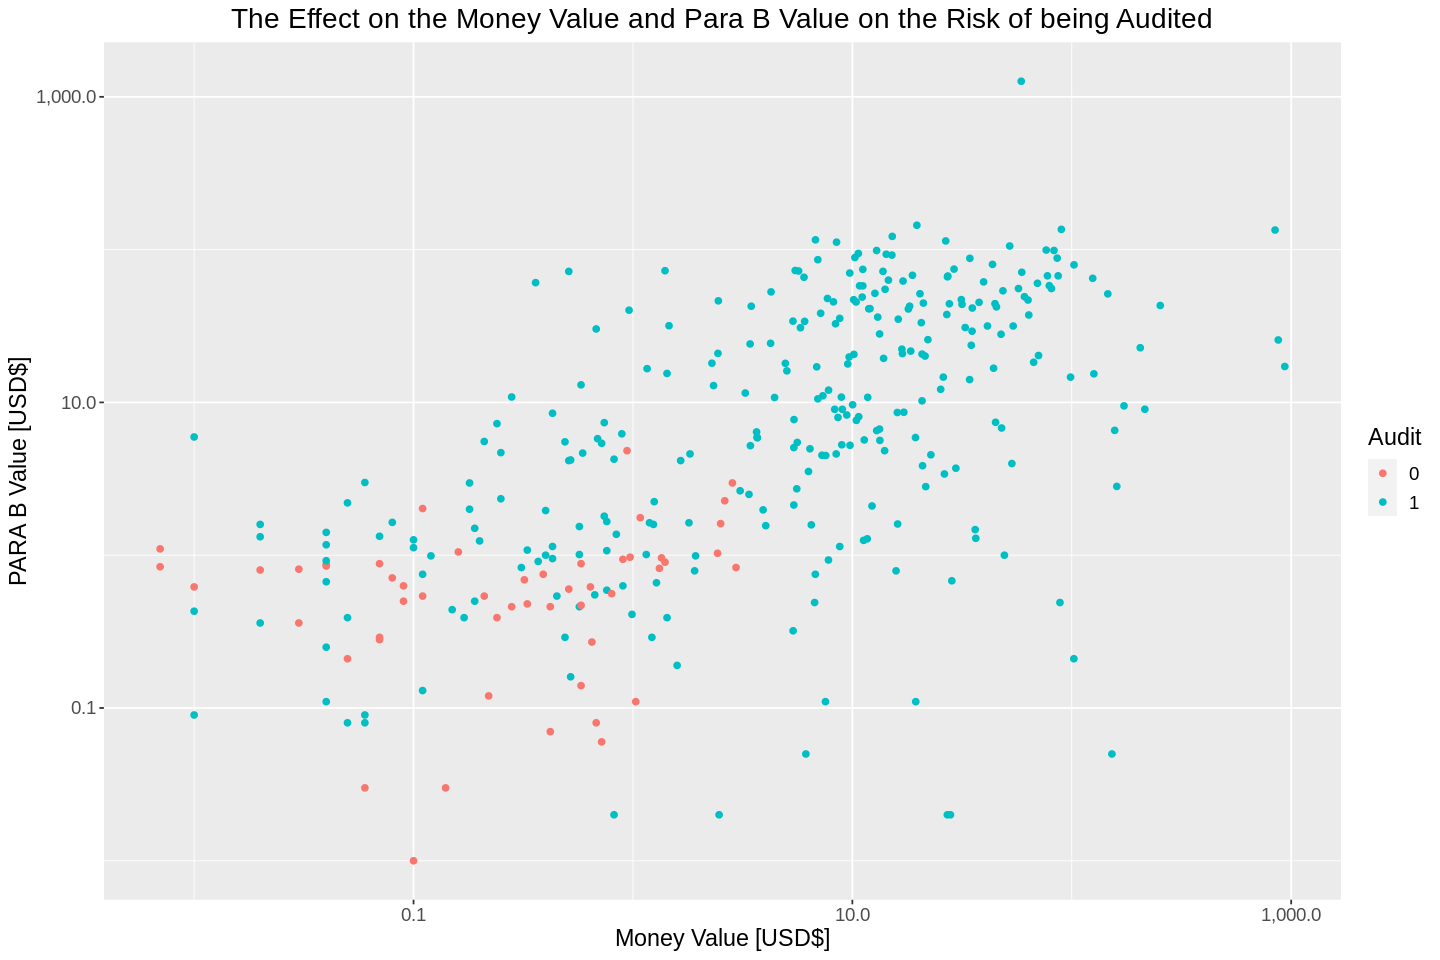

In [4]:
####EDGARS CODE
options(repr.plot.width = 12, repr.plot.height = 8) 
library(scales)
# Treat Risk as a categorical variable.
audit_trial <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk)) %>%
    filter(PARA_B > 0, Money_Value > 0)


# Plot our initial data (we are going to try to predict Risk). Money Value and PARA_B have very
# large and very small values. Hence a log scale might be more appropriate. We'll filter out
# the 0 values in these two since they will not help in our prediction. 

audit_plot <- audit_trial  %>%
    ggplot(aes(x = Money_Value, y = PARA_B, colour = Risk)) +
    geom_point() +
    labs(x = "Money Value [USD$]", y = "PARA B Value [USD$]", colour = "Audit") +
    ggtitle("The Effect on the Money Value and Para B Value on the Risk of being Audited") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) 
audit_plot

#As PARA_B value increases, so does the Money_Value. At that point all companies were audited

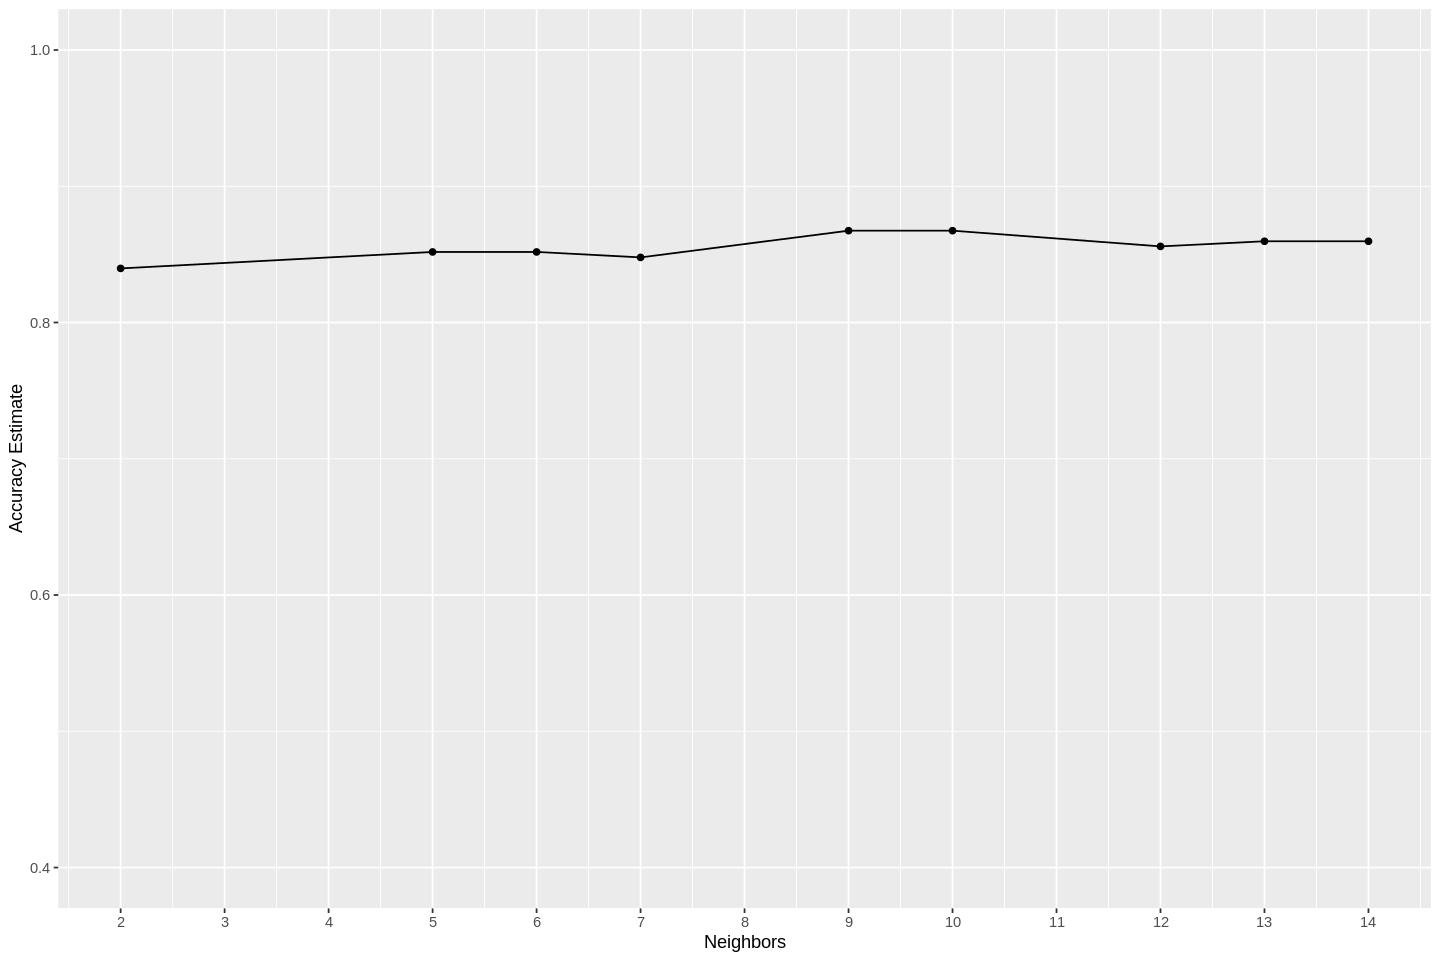

In [5]:
set.seed(1001)

# Splitting data into training and testing sets
audit_split <- initial_split(audit_trial, prop = 3/4, strata = Risk)  
audit_train <- training(audit_split)   
audit_test <- testing(audit_split)

# Training
audit_recipe <- recipe(Risk ~ PARA_B + Money_Value, data = audit_train) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

# tuning, how many K?
knn_tune <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_vfold <- vfold_cv(audit_train, v = 5, strata = Risk)

knn_results <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = 10) %>%
    collect_metrics()

accuracies <- knn_results %>% 
    filter(.metric == 'accuracy')

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k

In [6]:
## K = 9 seems to be the most accurate
audit_knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors = 9) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_fit <- workflow() %>%
    add_recipe(audit_recipe) %>%
    add_model(audit_knn_spec) %>%
    fit(data = audit_train)

audit_test_predictions <- predict(audit_fit, audit_test) %>%
    bind_cols(audit_test)

predictions_accuracy <- audit_test_predictions %>%
    metrics(truth = Risk, estimate = .pred_class)             

predictions_accuracy

audit_mat <- audit_test_predictions %>% 
    conf_mat(truth = Risk, estimate = .pred_class)   

audit_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8588235
kap,binary,0.4551282


          Truth
Prediction  0  1
         0  7  6
         1  6 66

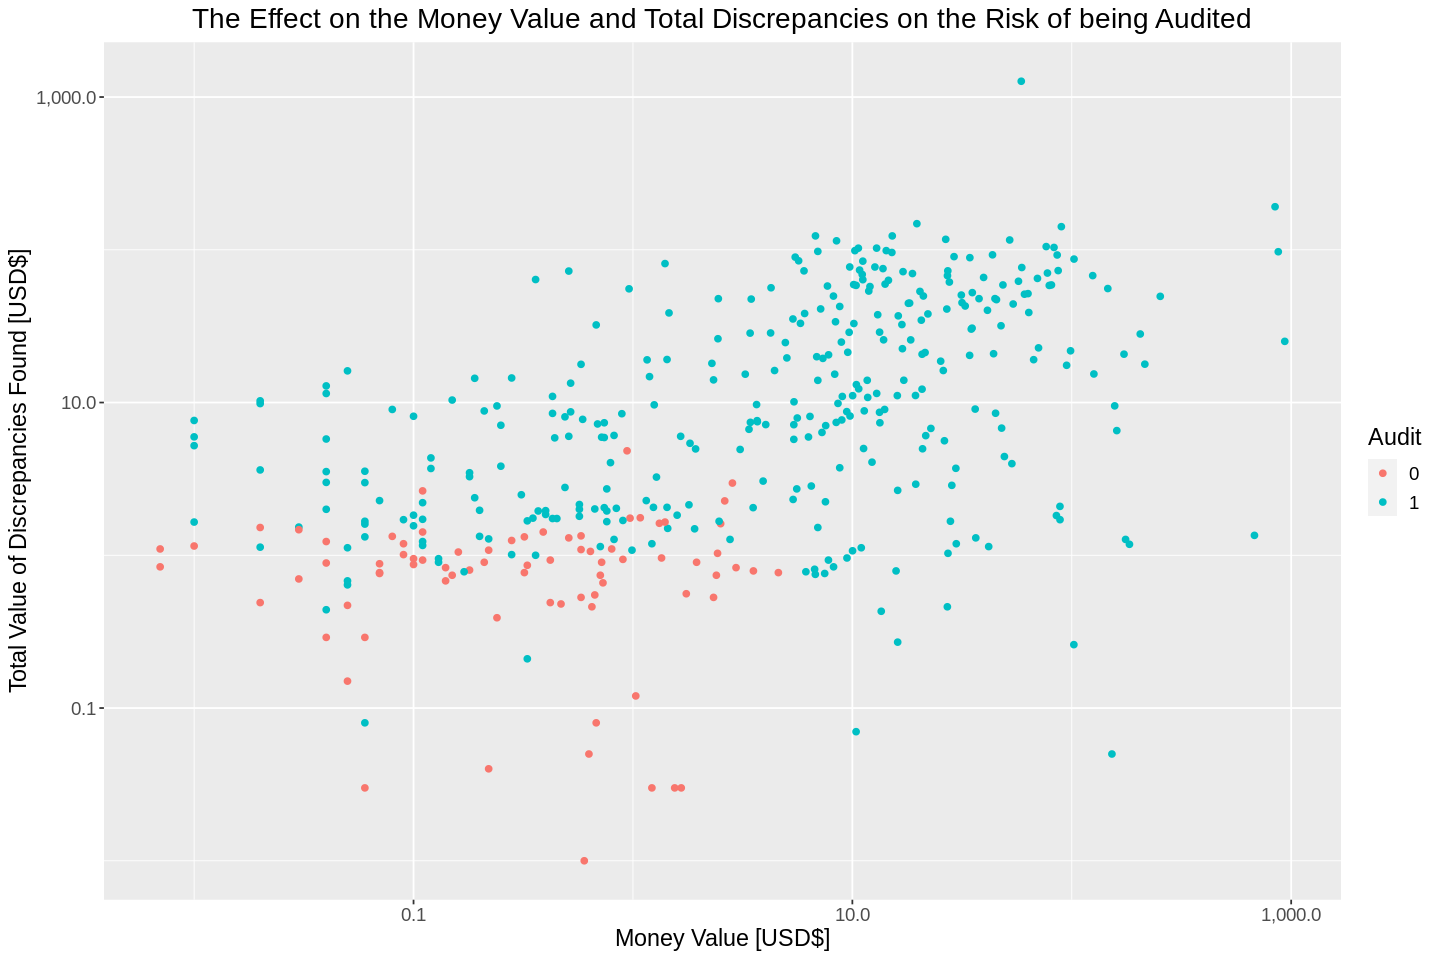

In [7]:
## SECOND APPROACH, I WANNA SEE THE RELATIONSHIP BETWEEN THE ACTUAL MONEY MADE AND LOST (total discrepancies)

####EDGARS CODE
options(repr.plot.width = 12, repr.plot.height = 8) 
library(scales)
# Treat Risk as a categorical variable.
audit_trial2 <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk)) %>%
    filter(TOTAL > 0, Money_Value > 0)

audit_plot_2 <- audit_trial2 %>%
    ggplot(aes(x = Money_Value, y = TOTAL, colour = Risk)) +
    geom_point() +
    labs(x = "Money Value [USD$]", y = "Total Value of Discrepancies Found [USD$]", colour = "Audit") +
    ggtitle("The Effect on the Money Value and Total Discrepancies on the Risk of being Audited") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) 
audit_plot_2

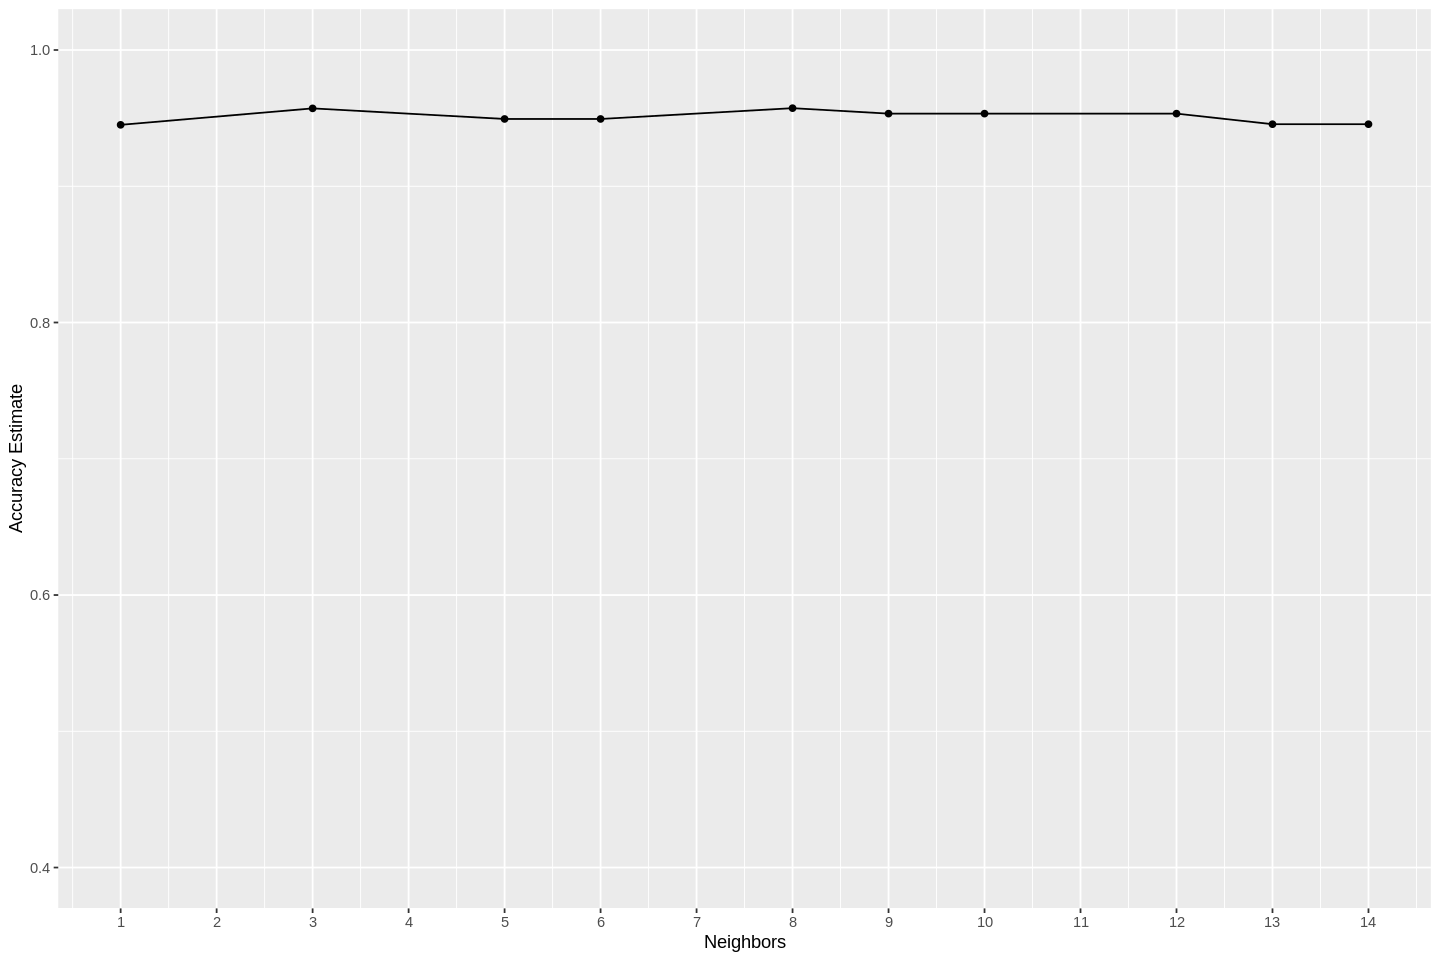

In [8]:

# Training (Historical discrepancy score (numbers) and the in unplanned expenditures (PARA_B))
audit_split2 <- initial_split(audit_trial2, prop = 3/4, strata = Risk)  
audit_train2 <- training(audit_split2)   
audit_test2 <- testing(audit_split2)

audit_recipe_2 <- recipe(Risk ~ numbers + TOTAL + Money_Value, data = audit_train2) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())


knn_results_2 <- workflow() %>%
    add_recipe(audit_recipe_2) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = 10) %>%
    collect_metrics()

accuracies_2 <- knn_results_2 %>% 
    filter(.metric == 'accuracy')

accuracy_versus_k2 <- ggplot(accuracies_2, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k2

In [9]:
## K = 3 seems to be the most accurate
audit_knn_spec2 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 3) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_fit2 <- workflow() %>%
    add_recipe(audit_recipe_2) %>%
    add_model(audit_knn_spec2) %>%
    fit(data = audit_train2)

audit_test_predictions2 <- predict(audit_fit2, audit_test2) %>%
    bind_cols(audit_test2)

predictions_accuracy2 <- audit_test_predictions2 %>%
    metrics(truth = Risk, estimate = .pred_class)             

predictions_accuracy2

audit_mat2 <- audit_test_predictions2 %>% 
    conf_mat(truth = Risk, estimate = .pred_class)   

audit_mat2

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9117647
kap,binary,0.7147296


          Truth
Prediction  0  1
         0 15  5
         1  4 78

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
`summarise()` ungrouping output (override with `.groups` argument)



Risk,n
<fct>,<int>
0,217
1,204


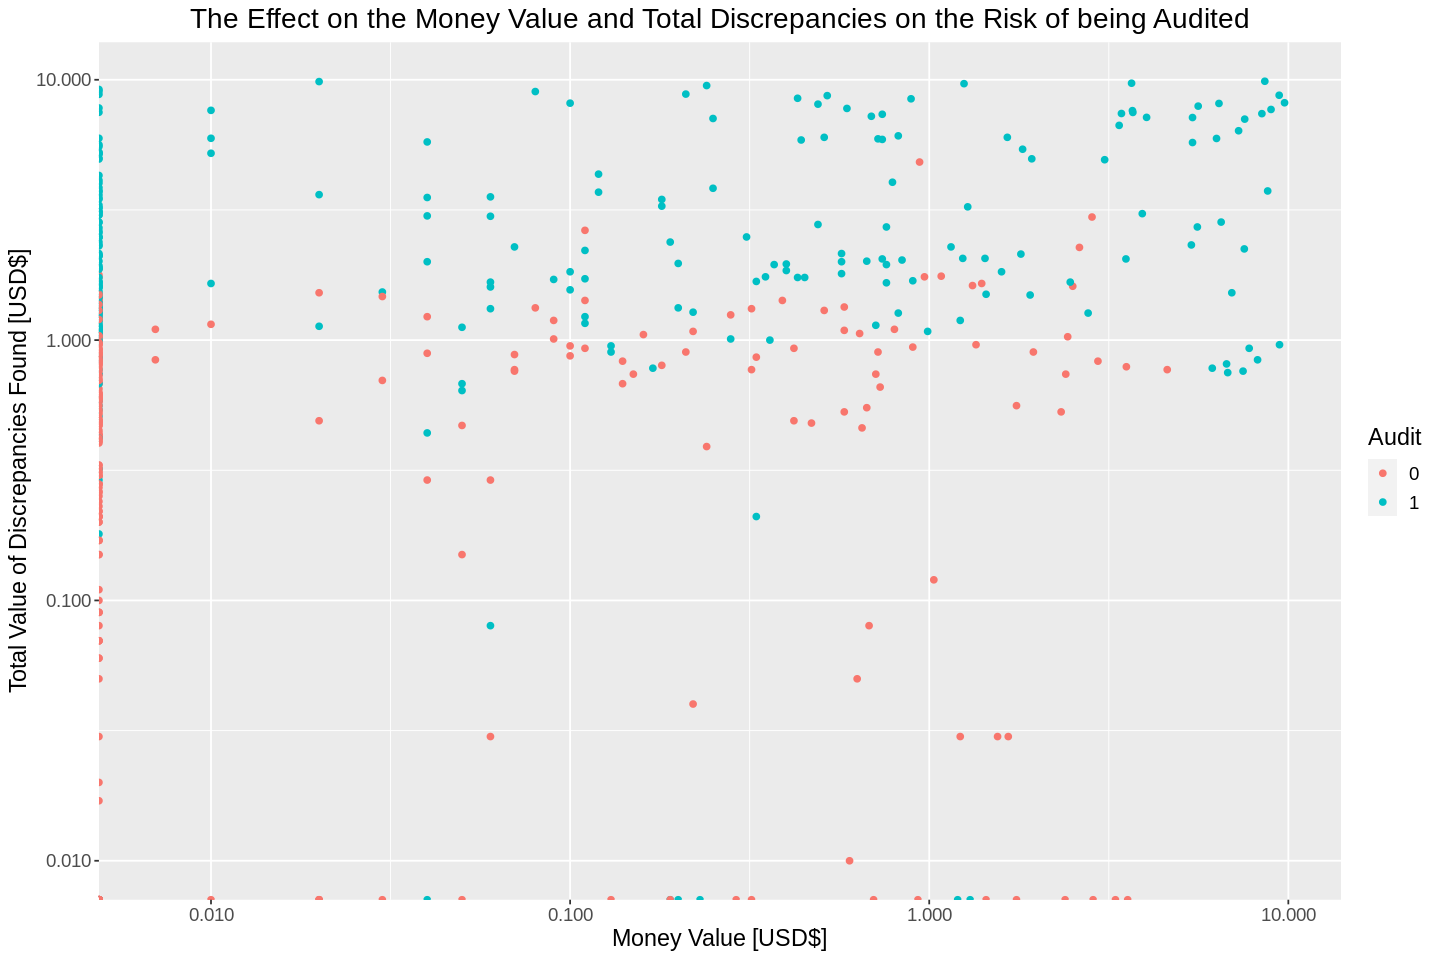

In [10]:
## Going to assume the second aproach is better
# Cleaning a wrangling our initial data, we want to use the original data


# We are interested in predicting the Risk Class, which are classified as 'Fraud' (1) or 'No-Fraud' (0)
# is the data evenly split in our training data? let's see


## Seems like most of our data is Fradulent firms, but looking at our visualization, we can see that all
## the firms that made a substantial amount of money were indeed auditted, so let's filter from our original
## data any high money making firms

audit_trial3 <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk)) %>%
    filter(TOTAL < 10, Money_Value < 10)

audit_plot_3 <- audit_trial3 %>%
    ggplot(aes(x = Money_Value, y = TOTAL, colour = Risk)) +
    geom_point() +
    labs(x = "Money Value [USD$]", y = "Total Value of Discrepancies Found [USD$]", colour = "Audit") +
    ggtitle("The Effect on the Money Value and Total Discrepancies on the Risk of being Audited") +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5)) +
    scale_x_log10(labels = label_comma()) +
    scale_y_log10(labels = label_comma()) 
audit_plot_3
## That looks more even, let's make another training set and count to make sure it is even

audit_split3 <- initial_split(audit_trial3, prop = 3/4, strata = Risk)  
audit_train3 <- training(audit_split3)   
audit_test3 <- testing(audit_split3)

## That looks much more even, we can assume that with this data if the values of either Money_value
## and TOTAL are over 10, the firm was Fraudulent
counts <- audit_train3 %>%
    group_by(Risk) %>%
    summarize(n = n())
counts


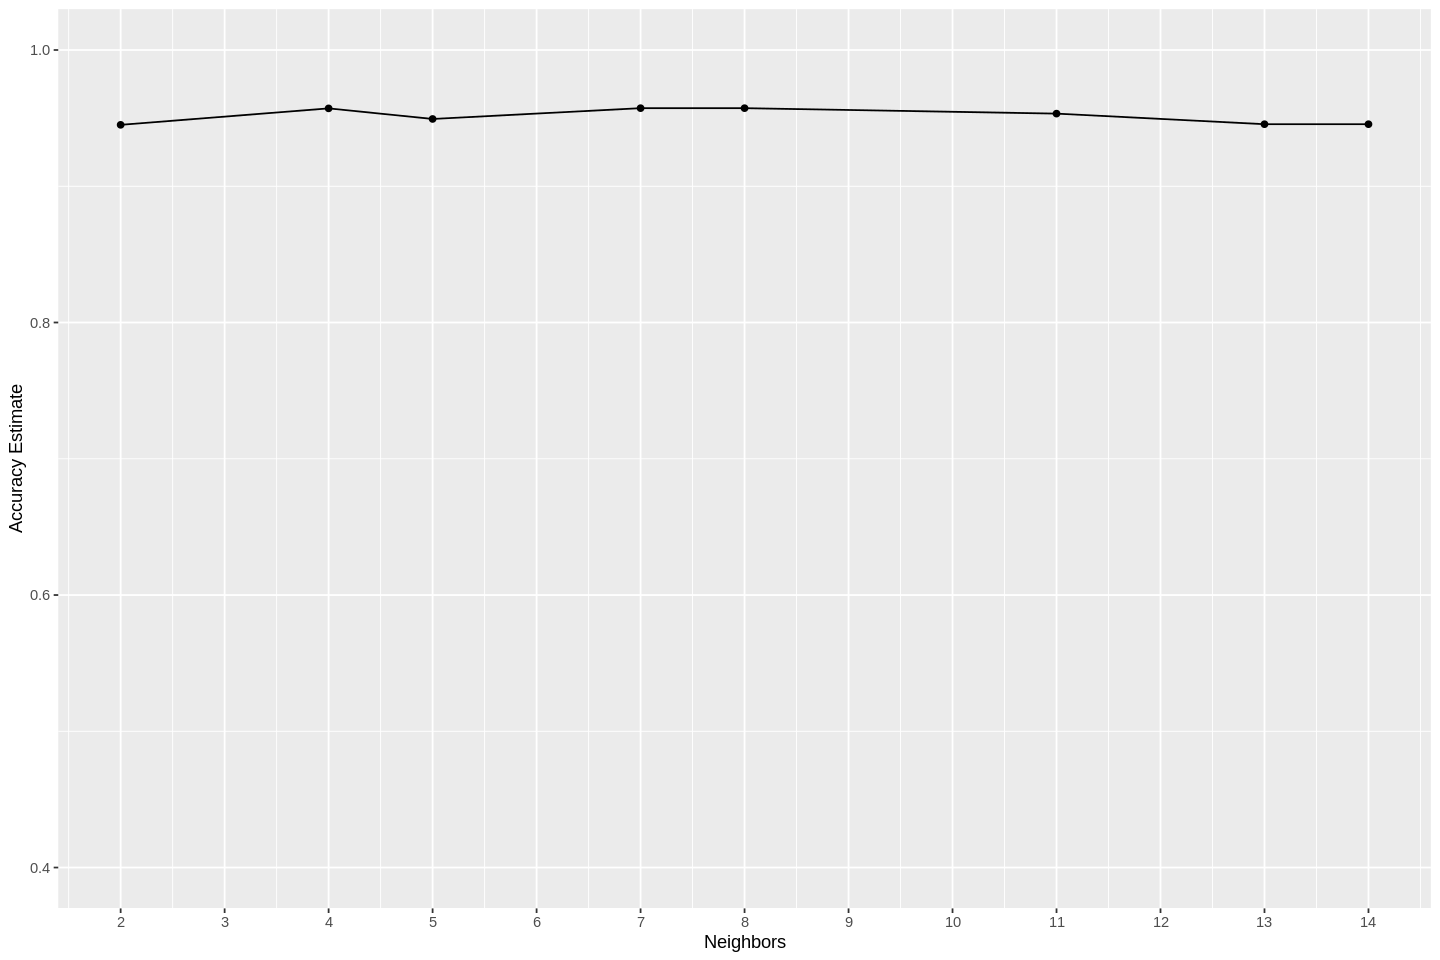

In [11]:
audit_recipe_3 <- recipe(Risk ~ numbers + TOTAL + Money_Value, data = audit_train3) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())


knn_results_3 <- workflow() %>%
    add_recipe(audit_recipe_3) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = 10) %>%
    collect_metrics()

accuracies_3 <- knn_results_3 %>% 
    filter(.metric == 'accuracy')

accuracy_versus_k3 <- ggplot(accuracies_3, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k3

In [12]:
## K = 4 seems to be the most accurate
audit_knn_spec3 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 4) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_fit3 <- workflow() %>%
    add_recipe(audit_recipe_3) %>%
    add_model(audit_knn_spec3) %>%
    fit(data = audit_train3)

audit_test_predictions3 <- predict(audit_fit3, audit_test3) %>%
    bind_cols(audit_test3)

predictions_accuracy3 <- audit_test_predictions3 %>%
    metrics(truth = Risk, estimate = .pred_class)             

predictions_accuracy3

audit_mat3 <- audit_test_predictions3 %>% 
    conf_mat(truth = Risk, estimate = .pred_class)   

audit_mat3

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.750000
kap,binary,0.500204


          Truth
Prediction  0  1
         0 53 16
         1 19 52

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



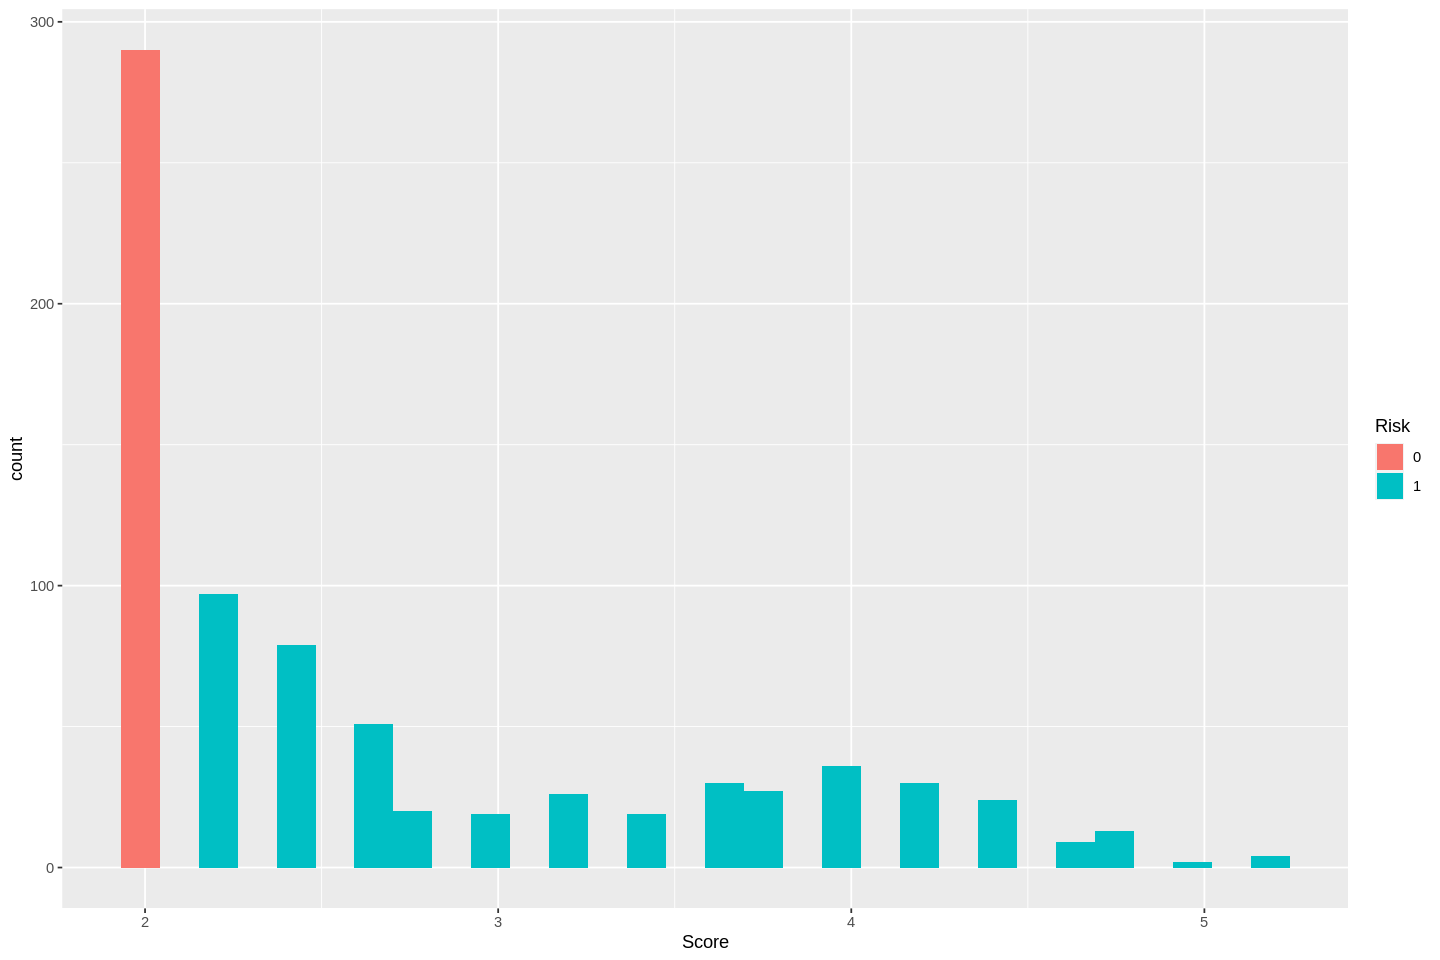

In [36]:
# Chyanne's try
# I want to figure out if we could use Score as a prediction in addition to Total and Money Value

options(repr.plot.width = 12, repr.plot.height = 8) 
library(scales)

# Change Risk to a factors so we can group it. 
audit_trial4 <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk))


#try to see the type of Score, but it seems it is alse like a catogorical variables.
#thing is wired because all Score=2 is non-Fraud firms. It may give us 100% accurate rate if we use it. 
audit_plot_4 <- ggplot(audit_trial4, aes(x = Score, fill=Risk)) +
  geom_histogram()

audit_plot_4



In [41]:
#we split data as usually, but I prefer to use 80% of data to see if we can get a accurate model. 
audit_split4 <- initial_split(audit_trial4, prop = 0.8, strata = Risk)  
audit_train4 <- training(audit_split4)   
audit_test4 <- testing(audit_split4)

#when I count for the number of frauds and non-frauds firms, much more fraud company existed in the training dataset.    
counts <- audit_train4 %>%
    group_by(Risk) %>%
    summarize(n = n())
counts



`summarise()` ungrouping output (override with `.groups` argument)



Risk,n
<fct>,<int>
0,233
1,389


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`summarise()` ungrouping output (override with `.groups` argument)



Risk,n
<fct>,<int>
0,232
1,218


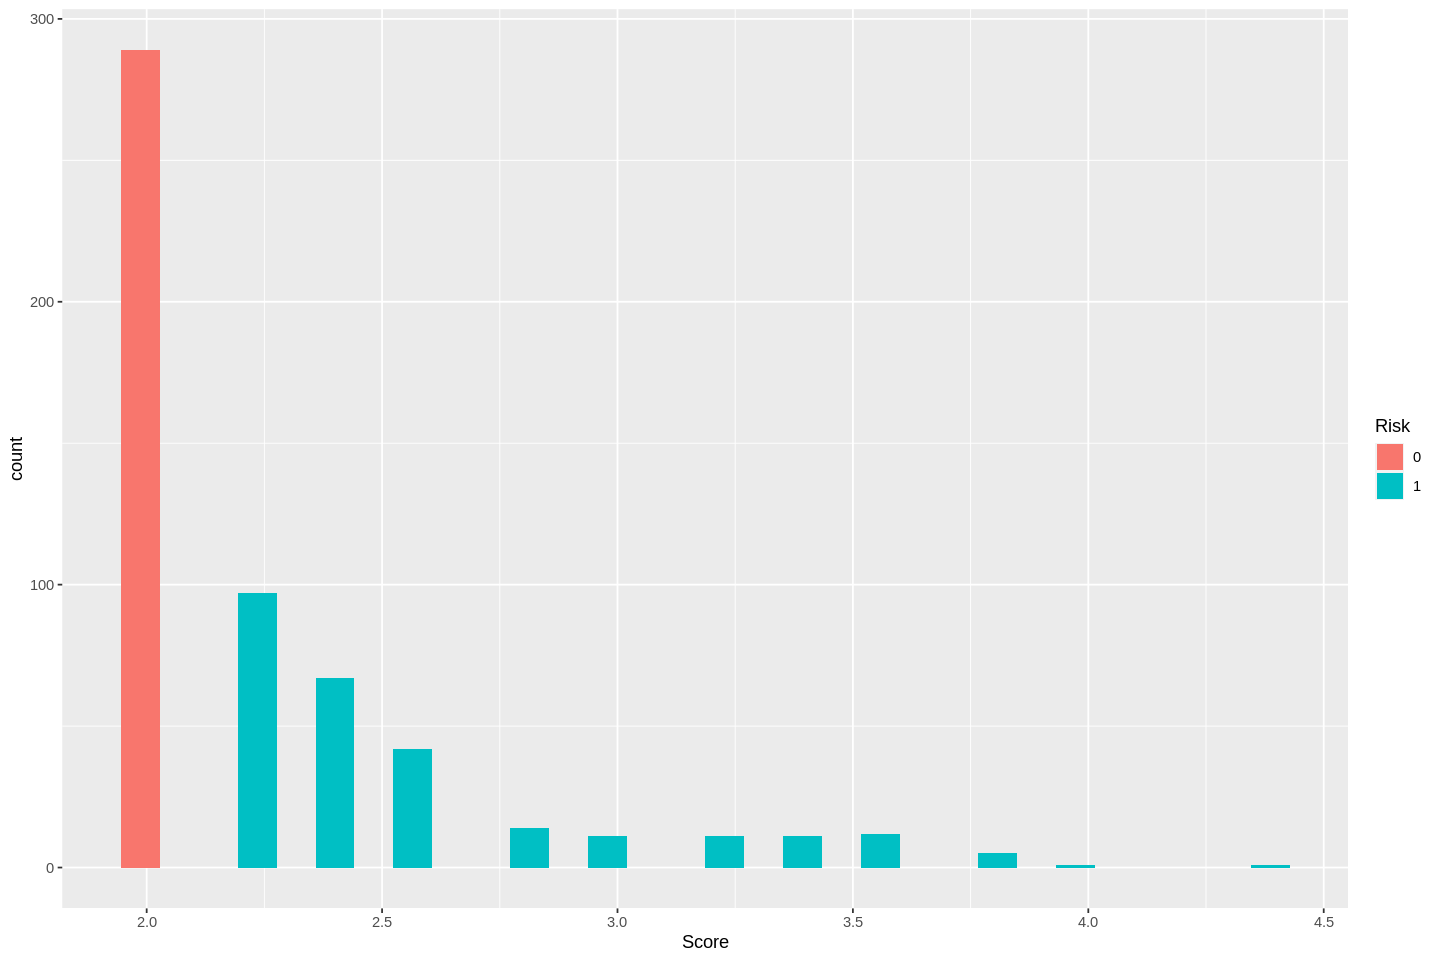

In [57]:
options(repr.plot.width = 12, repr.plot.height = 8) 
library(scales)
#So we can try to filter up the dataset to make the numbers more even. 
#Keep the reasonable filter Total and Money value both smaller than 10
audit_trial4.1 <- audit_trial_data %>%
    mutate(Risk = as_factor(Risk)) %>%
    filter(Score<5 , TOTAL <10, Money_Value <10)


#plot histogram again
audit_plot_4.1 <- ggplot(audit_trial4.1, aes(x = Score, fill=Risk)) +
  geom_histogram()

audit_plot_4.1

#we split data as usually.
audit_split4.1 <- initial_split(audit_trial4.1, prop = 0.8, strata = Risk)  
audit_train4.1 <- training(audit_split4.1)   
audit_test4.1 <- testing(audit_split4.1)

#count the number of firms in training dataset again. Now the numbers are closed.
counts_4.1 <- audit_train4.1 %>%
    group_by(Risk) %>%
    summarize(n = n())
counts_4.1

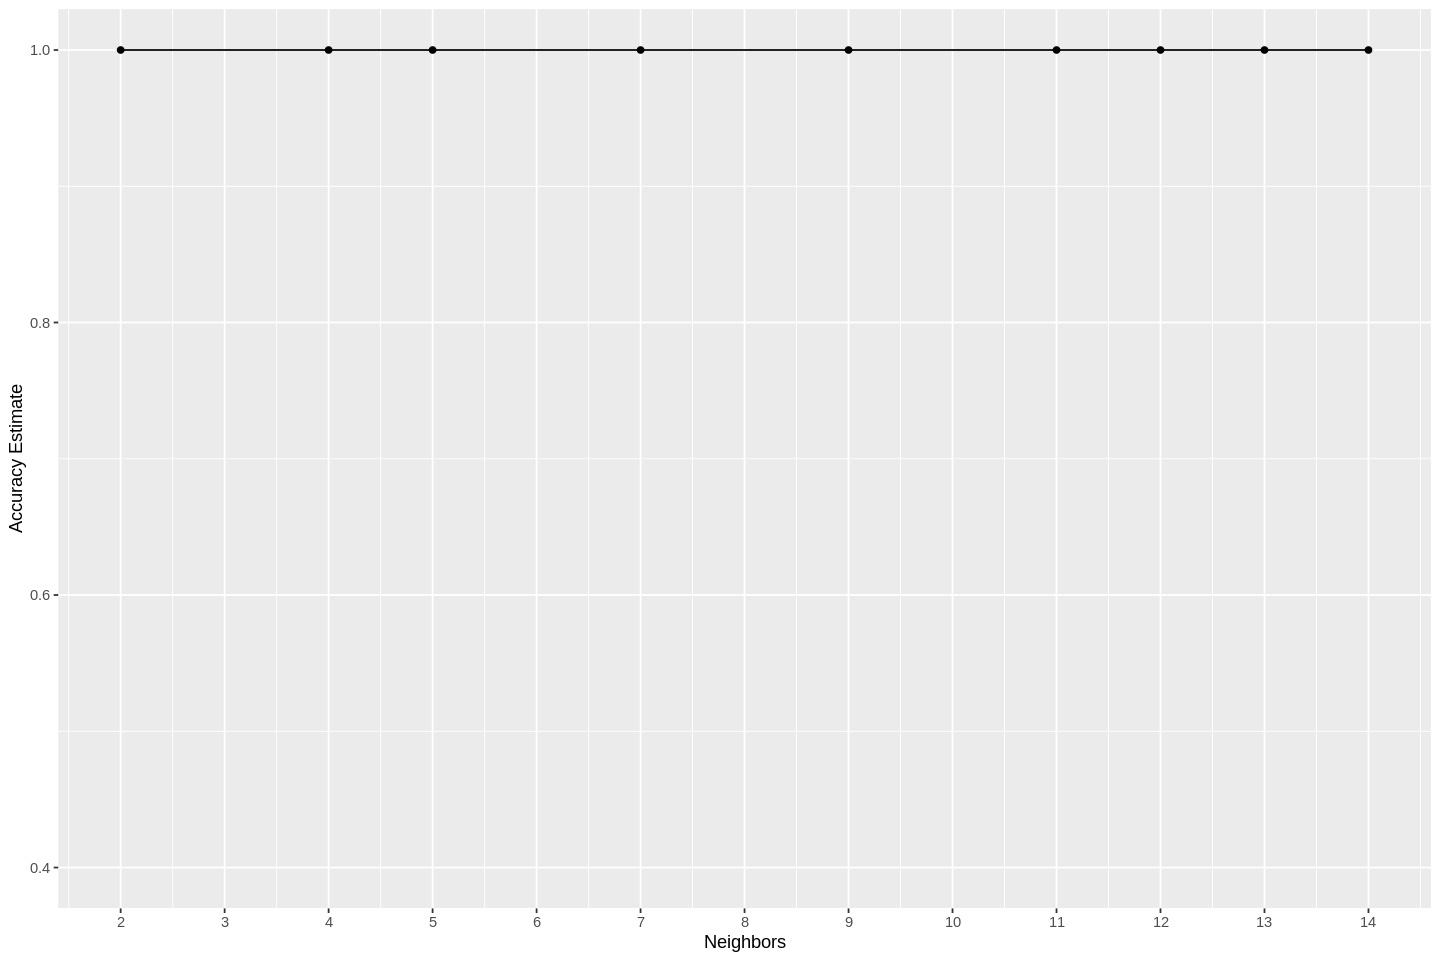

In [62]:
# add Score in addition to total and money value

audit_recipe_4.1 <- recipe(Risk ~ TOTAL+ Money_Value + Score, data =audit_train4.1) %>%
    step_scale(all_predictors())%>%
    step_center(all_predictors())

# Find K
knn_tune_4.1 <- nearest_neighbor(weight_func = 'rectangular', neighbors = tune()) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_vfold_4.1 <- vfold_cv(audit_train4.1, v = 5, strata = Risk)


knn_results_4.1 <- workflow() %>%
    add_recipe(audit_recipe_4.1) %>%
    add_model(knn_tune) %>%
    tune_grid(resamples = audit_vfold, grid = 10) %>%
    collect_metrics()

accuracies_4.1 <- knn_results_4.1 %>% 
    filter(.metric == 'accuracy')

accuracy_versus_k4.1 <- ggplot(accuracies_4.1, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis

accuracy_versus_k4.1



In [63]:
# acutrally, I dont see any differences now. It think is due to the Score is more like a catogorical variable. 
# I will try K= 8 seems to be the most accurate
audit_knn_spec4.1 <- nearest_neighbor(weight_func = 'rectangular', neighbors = 8) %>%
    set_engine('kknn') %>%
    set_mode('classification')

audit_fit4.1 <- workflow() %>%
    add_recipe(audit_recipe_4.1) %>%
    add_model(audit_knn_spec4.1) %>%
    fit(data = audit_train4.1)

audit_test_predictions4.1 <- predict(audit_fit4.1, audit_test4.1) %>%
    bind_cols(audit_test4.1)

predictions_accuracy4.1 <- audit_test_predictions4.1 %>%
    metrics(truth = Risk, estimate = .pred_class)             

predictions_accuracy4.1

audit_mat4.1 <- audit_test_predictions %>% 
    conf_mat(truth = Risk, estimate = .pred_class)   

audit_mat4.1





.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,1
kap,binary,1


          Truth
Prediction  0  1
         0  7  6
         1  6 66

I have tried several times with the predictors para a, para b, Total, money value and ARS(Score) as predictors (Total 5 predictors) because I think they are all resonable. When I discuss with Edgar, I choose to eliminate para a and para b and use Total instead becuase the Total is the sum of para a and b. Then we only need to focus on Total and Money Value and Score. However, whenever I add Score as a predictor, I always get the accuracy of 100%. I think it is because Score being more like a catogorical varialbe than a numerical variable. Score=2 includes all non-fraud firms and Score >2 are all fraud firms. So I do not think Score is an effective predictor.  